### Imports and filling missing values

In [94]:
import altair as alt
import pandas as pd 
import numpy as np 
import matplotlib as plt 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
#!pip install xgboost
import xgboost as xgb
from sklearn.metrics import accuracy_score
#!pip install lightgbm
#import lightgbm as lgb
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import spearmanr
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.metrics import median_absolute_error

In [104]:
!pip install tqdm

14498.94s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 638.9 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.3/78.3 kB 3.0 MB/s eta 0:00:00


In [111]:
from tqdm import tqdm

In [10]:
def encode(x): 
    if x == 'FR':
        return 1
    if x == "DE": 
        return 0

In [11]:
### impoerting all the data 

X_train = pd.read_csv('/Users/federicobianchi/Uni /EL/files/prog1_dataset/X_train.csv')
Y_train = pd.read_csv('/Users/federicobianchi/Uni /EL/files/prog1_dataset/y_train.csv')
X_test = pd.read_csv('/Users/federicobianchi/Uni /EL/files/prog1_dataset/X_test.csv')
Y_test = pd.read_csv('/Users/federicobianchi/Uni /EL/files/prog1_dataset/y_test.csv')

Train_df = X_train.merge(Y_train)
Test_df = X_test.merge(Y_test)

In [12]:
Train_df['COUNTRY'] = Train_df['COUNTRY'].apply(lambda x: encode(x))
Test_df['COUNTRY'] = Test_df['COUNTRY'].apply(lambda x: encode(x))

Train_df.sort_values('DAY_ID',inplace=True)
Test_df.sort_values('DAY_ID', inplace=True)

#interpolating to fill the missing values

Train_df = Train_df.interpolate(method='polynomial', order=3)
Test_df = Test_df.interpolate(method='polynomial', order=3)
Train_df = Train_df.fillna(0)
Test_df = Test_df.fillna(0)

In [13]:
# we will only work on the france DataSet 

Train_df = Train_df[Train_df['COUNTRY'] == 1]
Test_df = Test_df[Test_df['COUNTRY'] == 1]

X_train = Train_df.drop('TARGET', axis=1)
Y_train = Train_df['TARGET']

X_test = Test_df.drop('TARGET', axis=1)
Y_test = Test_df['TARGET']

In [19]:
X_train.columns

Index(['ID', 'DAY_ID', 'COUNTRY', 'DE_CONSUMPTION', 'FR_CONSUMPTION',
       'DE_FR_EXCHANGE', 'FR_DE_EXCHANGE', 'DE_NET_EXPORT', 'FR_NET_EXPORT',
       'DE_NET_IMPORT', 'FR_NET_IMPORT', 'DE_GAS', 'FR_GAS', 'DE_COAL',
       'FR_COAL', 'DE_HYDRO', 'FR_HYDRO', 'DE_NUCLEAR', 'FR_NUCLEAR',
       'DE_SOLAR', 'FR_SOLAR', 'DE_WINDPOW', 'FR_WINDPOW', 'DE_LIGNITE',
       'DE_RESIDUAL_LOAD', 'FR_RESIDUAL_LOAD', 'DE_RAIN', 'FR_RAIN', 'DE_WIND',
       'FR_WIND', 'DE_TEMP', 'FR_TEMP', 'GAS_RET', 'COAL_RET', 'CARBON_RET'],
      dtype='object')

In [29]:
col_2_keep = ['FR_CONSUMPTION', 'FR_DE_EXCHANGE', 'FR_GAS', 'FR_COAL', 'FR_HYDRO', 'FR_NUCLEAR',
              'FR_SOLAR', 'FR_WINDPOW', 'FR_RAIN', 'FR_TEMP', 'FR_WIND']

In [32]:
X_train_min = X_train[col_2_keep]
X_test_min = X_test[col_2_keep]

In [33]:
scaler = MinMaxScaler()

MM_X_train_min = scaler.fit_transform(X_train_min)
MM_X_test_min = scaler.transform(X_test_min)
MM_Y_train = scaler.fit_transform(Y_train.values.reshape(-1, 1))
MM_Y_test = scaler.transform(Y_test.values.reshape(-1, 1))


In [35]:
MM_X_train_min = pd.DataFrame(MM_X_train_min, columns=col_2_keep)
MM_X_test_min = pd.DataFrame(MM_X_test_min, columns=col_2_keep)
MM_Y_train = pd.DataFrame(MM_Y_train, columns=['TARGET'])
MM_Y_test = pd.DataFrame(MM_Y_test, columns=['TARGET'])

In [36]:
MM_X_train_min

,FR_CONSUMPTION,FR_DE_EXCHANGE,FR_GAS,FR_COAL,FR_HYDRO,FR_NUCLEAR,FR_SOLAR,FR_WINDPOW,FR_RAIN,FR_TEMP,FR_WIND
0,0.209382,0.494223,0.286127,0.329628,0.443726,0.502987,0.503426,0.043965,0.082578,0.738794,0.145930
1,0.563612,0.419446,0.896599,0.003126,0.449652,0.893739,0.362504,0.158966,0.114435,0.697944,0.094330
2,0.166904,0.680453,0.481217,0.010385,0.150911,0.498029,0.472640,0.048932,0.125569,0.745446,0.170318
3,0.131805,0.671294,0.375793,0.028225,0.250471,0.228355,0.866496,0.069509,0.059300,0.560800,0.369562
4,0.208268,0.453450,0.500180,0.010697,0.247831,0.163901,0.955035,0.082318,0.088452,0.840363,0.303822
...,...,...,...,...,...,...,...,...,...,...,...
846,0.158165,0.401852,0.405721,0.013468,0.250965,0.155451,0.478465,0.110520,0.394976,0.504204,0.389499
847,0.580184,0.194708,0.606179,0.356502,0.488093,0.816116,0.333193,0.356396,0.140626,0.626195,0.235445
848,0.197742,0.529043,0.526571,0.006726,0.155263,0.260881,0.584951,0.143490,0.137535,0.635343,0.459036
849,0.582744,0.562841,0.776990,0.186338,0.672672,0.641398,0.190938,0.563461,0.117828,0.496941,0.211672


### MM set 

#### Linear Regression MM set 

In [41]:
linear_model = LinearRegression()
linear_model.fit(MM_X_train_min, MM_Y_train)
Y_pred = linear_model.predict(MM_X_test_min)
Y_pred_train = linear_model.predict(MM_X_train_min)

mse = mean_squared_error(MM_Y_test, Y_pred)
r2 = r2_score(MM_Y_test, Y_pred)
mae = mean_absolute_error(MM_Y_test, Y_pred)

print('Mean Squared Error:', mse)
print('Mean Absolute Error:', mae)
print('R2:', r2)

#spierceman correlation

correlation, _ = spearmanr(MM_Y_test, Y_pred)
print('Spearmans correlation: %.3f' % correlation)

Mean Squared Error: 0.005623229687085296
Mean Absolute Error: 0.060335924423168034
R2: -0.03389087487846809
Spearmans correlation: -0.043


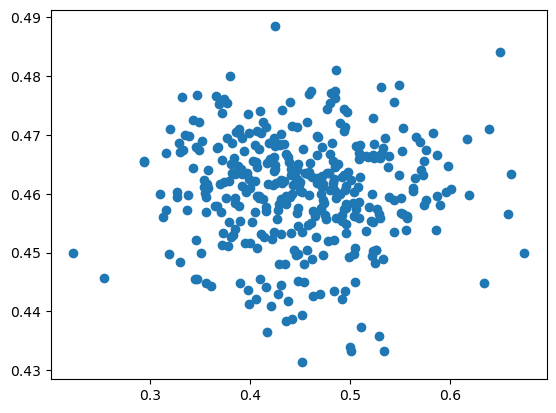

In [39]:
plt.title('Pred vs Real (test)')
plt.plot(MM_Y_test, Y_pred, 'o')


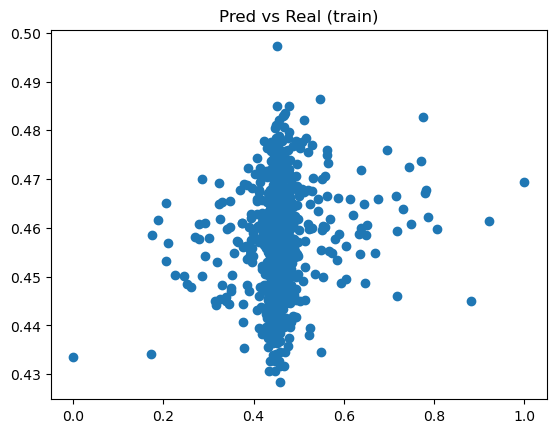

In [42]:
plt.title('Pred vs Real (train)')
plt.plot(MM_Y_train, Y_pred_train, 'o')

#### XGBoost 

In [43]:
# Create and train the XGBoost regresso

xgb_regressor = xgb.XGBRegressor()
xgb_regressor.fit(MM_X_train_min, MM_Y_train)

# Make predictions
Y_pred = xgb_regressor.predict(MM_X_test_min)
MM_Y_train_pred = xgb_regressor.predict(MM_X_train_min)

# Compute evaluation metrics
mae = mean_absolute_error(MM_Y_test, Y_pred)
mse = mean_squared_error(MM_Y_test, Y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(MM_Y_test, Y_pred)

# Compute Spearman's correlation coefficient
spearman_corr, spearman_p_value = spearmanr(MM_Y_test, Y_pred)

# Print the evaluation metrics
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared (R²):", r2)
print("Spearman's correlation coefficient:", spearman_corr)

Mean Absolute Error (MAE): 0.06812507033176404
Mean Squared Error (MSE): 0.0073540613804570654
Root Mean Squared Error (RMSE): 0.08575582417805257
R-squared (R²): -0.3521227795501536
Spearman's correlation coefficient: 0.011150897160329005


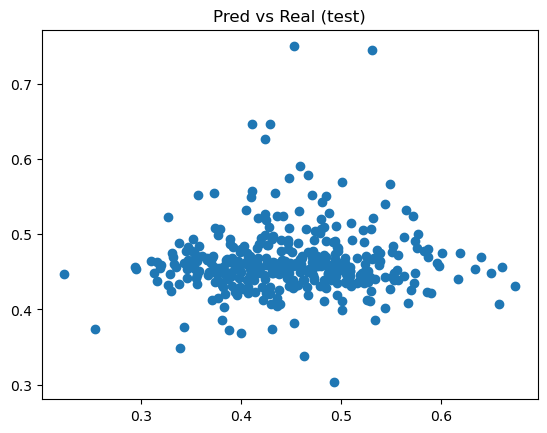

In [44]:
plt.title('Pred vs Real (test)')
plt.plot(MM_Y_test, Y_pred, 'o')

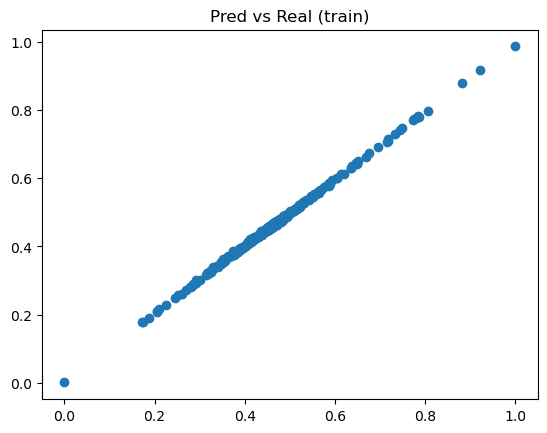

In [47]:
plt.title('Pred vs Real (train)')
plt.plot(MM_Y_train, MM_Y_train_pred, 'o')

##### Optimization

In [66]:
# optimizing XGBoost hyperparameters

param_dist = {
    'n_estimators': [100, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000],
    'learning_rate': [0.1, 0.01, 0.001],
    'max_depth': [3, 4, 5, 6, 7, 8],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4, 0.5],
    'reg_alpha': [0, 0.01, 0.1, 1, 10],
    'reg_lambda': [0.01, 0.1, 1, 10, 100]
}


In [67]:
xgb_regressor = xgb.XGBRegressor()

random_search = RandomizedSearchCV(estimator=xgb_regressor, 
                                   param_distributions=param_dist, 
                                   n_iter=100, 
                                   scoring='neg_mean_squared_error', 
                                   cv=5, 
                                   verbose=2, 
                                   random_state=42, 
                                   n_jobs=-1)


In [68]:
random_search.fit(MM_X_train_min, MM_Y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END colsample_bytree=1.0, gamma=0.3, learning_rate=0.1, max_depth=5, n_estimators=500, reg_alpha=0.01, reg_lambda=0.1, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.3, learning_rate=0.1, max_depth=5, n_estimators=500, reg_alpha=0.01, reg_lambda=0.1, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.3, learning_rate=0.1, max_depth=5, n_estimators=500, reg_alpha=0.01, reg_lambda=0.1, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.3, learning_rate=0.1, max_depth=5, n_estimators=500, reg_alpha=0.01, reg_lambda=0.1, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.3, learning_rate=0.1, max_depth=5, n_estimators=500, reg_alpha=0.01, reg_lambda=0.1, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.001, max_depth=7, n_estimators=3500, reg_alpha=1, reg_lambda=0.1, subsample=0.9; total ti

RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                   param_distributions={'colsample_bytree': [0.6, 0.7, 0.8, 0.9,
                                                             1.0],
                                        'gamma': [0, 0.1, 0.2, 0.3, 0.4, 0.5],
                                        'learning_rate': [0.1, 0.01, 0.001],
                                        'max_depth': [3, 4, 5, 6, 7, 8],
                                        'n_estimators': [100, 500, 1000, 1500,
                                                         2000, 2500, 3000, 3500,
                                                         4000, 4500, 5000],
                                        'reg_alpha': [0, 0.01, 0.1, 1, 10],
                                        'reg_lambda': [0.01, 0.1, 1, 10, 100],
                                        'subsample': [0.6, 0.7, 0.8, 0.9, 1.0]},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=2)

In [69]:
print("Best parameters:", random_search.best_params_)
best_model = random_search.best_estimator_
# You can now evaluate the best_model on your test data or use it for further predictions

Best parameters: {'subsample': 0.7, 'reg_lambda': 0.1, 'reg_alpha': 0.01, 'n_estimators': 3500, 'max_depth': 6, 'learning_rate': 0.1, 'gamma': 0.2, 'colsample_bytree': 1.0}


In [97]:
# Make predictions
Best_Y_pred = best_model.predict(MM_X_test_min)
Best_Y_train_pred = best_model.predict(MM_X_train_min)

# Compute evaluation metrics
mae = mean_absolute_error(MM_Y_test, Best_Y_pred)
mse = mean_squared_error(MM_Y_test, Best_Y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(MM_Y_test, Best_Y_pred)

# Compute Spearman's correlation coefficient
spearman_corr, spearman_p_value = spearmanr(MM_Y_test, Best_Y_pred)

# Print the evaluation metrics
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared (R²):", r2)
print("Spearman's correlation coefficient:", spearman_corr)



Mean Absolute Error (MAE): 0.059646978965648016
Mean Squared Error (MSE): 0.005489236283733513
Root Mean Squared Error (RMSE): 0.07408938037082989
R-squared (R²): -0.009254755650138113
Spearman's correlation coefficient: nan


/Users/federicobianchi/anaconda3/envs/UNi_anaconda/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


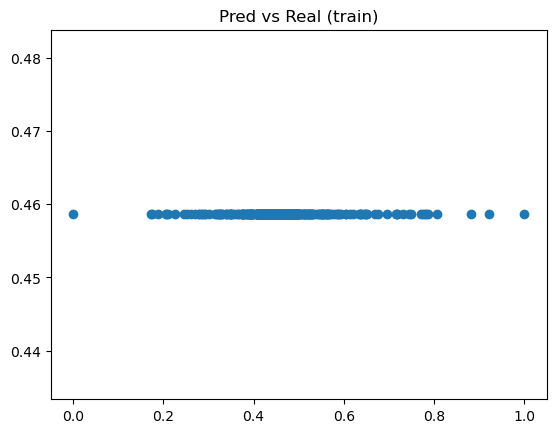

In [98]:
plt.title('Pred vs Real (train)')
plt.plot(MM_Y_train, Best_Y_train_pred, 'o')

In [114]:
MM_Y_test

,TARGET
0,0.524785
1,0.367752
2,0.441369
3,0.473836
4,0.464975
...,...
360,0.389261
361,0.410754
362,0.381433
363,0.482540


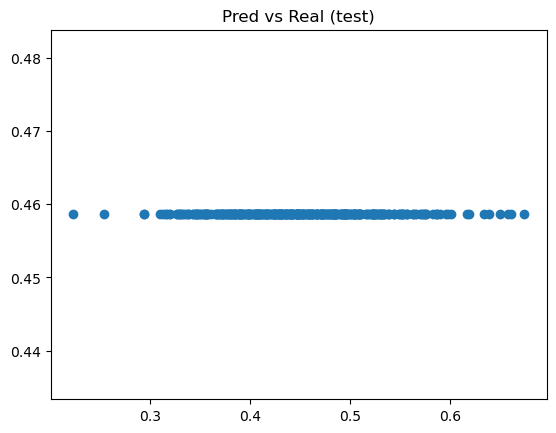

In [113]:
plt.title('Pred vs Real (test)')
plt.plot(MM_Y_test, Best_Y_pred, 'o')

In [88]:
from sklearn.ensemble import RandomForestRegressor

# Create and train the Random Forest regressor
rf_regressor = RandomForestRegressor(n_estimators=1000, random_state=42, n_jobs=-1, max_features="sqrt", oob_score=True, criterion="poisson")
rf_regressor.fit(MM_X_train_min, MM_Y_train)

# Make predictions
rf_Y_pred = rf_regressor.predict(MM_X_test_min)
rf_Y_train_pred = rf_regressor.predict(MM_X_train_min)

# Compute evaluation metrics
mae = mean_absolute_error(MM_Y_test, rf_Y_pred)
mse = mean_squared_error(MM_Y_test, rf_Y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(MM_Y_test, rf_Y_pred)
spearman_corr, spearman_p_value = spearmanr(MM_Y_test, rf_Y_pred)

# Print the evaluation metrics  
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared (R²):", r2)
print("Spearman's correlation coefficient:", spearman_corr)



/Users/federicobianchi/anaconda3/envs/UNi_anaconda/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Mean Absolute Error (MAE): 0.06127318167638712
Mean Squared Error (MSE): 0.005786447312326061
Root Mean Squared Error (RMSE): 0.07606870126619791
R-squared (R²): -0.06390017962789396
Spearman's correlation coefficient: 0.028193611912453148


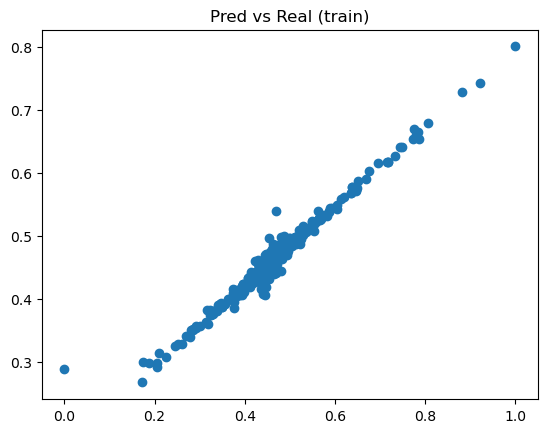

In [89]:
plt.title('Pred vs Real (train)')
plt.plot(MM_Y_train, rf_Y_train_pred, 'o')

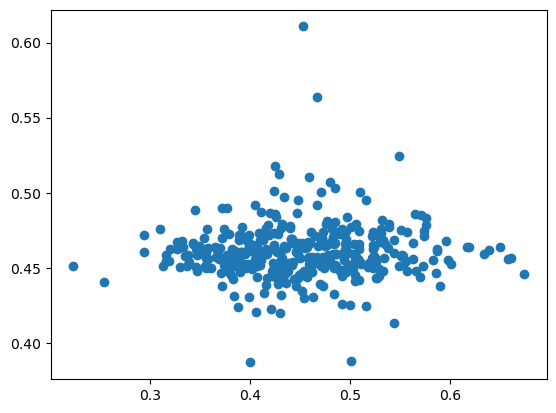

In [90]:
plt.plot(MM_Y_test, rf_Y_pred, 'o')

### Testing and comparing all models 

In [103]:
# Initialize models
models = {
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42),
    "AdaBoost": AdaBoostRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    #"XGBoost": xgb_regressor(random_state=42, objective='reg:squarederror')  
}

# Dictionary to store evaluation metrics and feature importance
results_test = {"Model": [], "MSE": [], "MAE": [], "RMSE": [], "MedAE": [], "R2": [], "spearmanr": []}

# Train, predict, and evaluate each model
for model_name, model in models.items():
    # Train the model
    model.fit(MM_X_train_min, MM_Y_train)

    # Predict on the testing set
    y_pred = model.predict(MM_X_test_min)

    # Calculate evaluation metrics
    mse = mean_squared_error(MM_Y_test, y_pred)
    mae = mean_absolute_error(MM_Y_test, y_pred)
    rmse = np.sqrt(mse)
    medae = median_absolute_error(MM_Y_test, y_pred)
    r2 = r2_score(MM_Y_test, y_pred)
    spearmanr_val = spearmanr(y_pred, MM_Y_test).correlation


    # Store results
    results_test["Model"].append(model_name)
    results_test["MSE"].append(mse)
    results_test["MAE"].append(mae)
    results_test["RMSE"].append(rmse)
    results_test["MedAE"].append(medae)
    results_test["R2"].append(r2)
    results_test["spearmanr"].append(spearmanr_val)


# Convert results to DataFrame for easy visualization
results_test_df_DE = pd.DataFrame(results_test)
results_test_df_DE


/Users/federicobianchi/anaconda3/envs/UNi_anaconda/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/federicobianchi/anaconda3/envs/UNi_anaconda/lib/python3.11/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/federicobianchi/anaconda3/envs/UNi_anaconda/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,Model,MSE,MAE,RMSE,MedAE,R2,spearmanr
0,Decision Tree,0.010435,0.074443,0.102149,0.058166,-0.918498,0.080272
1,Random Forest,0.006217,0.063158,0.078850,0.054879,-0.143114,-0.006970
2,AdaBoost,0.007620,0.070542,0.087292,0.062553,-0.400983,0.027019
3,Gradient Boosting,0.006411,0.063295,0.080067,0.056090,-0.178671,0.006347


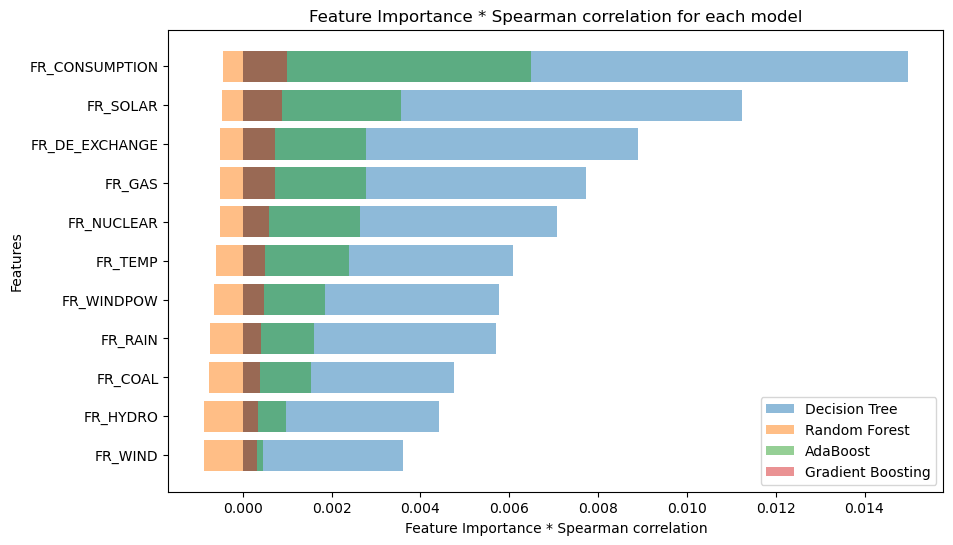

In [102]:

plt.figure(figsize=(10, 6))

# Assuming 'models' is your dictionary of models,
# and 'results_test_df_DE' contains the Spearman correlation results for each model
for model_name, model in models.items():
    # Get feature importance for the current model
    feature_importance = model.feature_importances_
    # Get Spearman correlation value for the current model
    spearmanr_val = results_test_df_DE.loc[results_test_df_DE['Model'] == model_name, 'spearmanr'].values[0]
    # Calculate importance multiplied by Spearman correlation
    importance_spearmanr = feature_importance * spearmanr_val
    
    # Sort the features by importance
    sorted_idx = np.argsort(importance_spearmanr)
    sorted_importance_spearmanr = importance_spearmanr[sorted_idx]
    sorted_feature_names = MM_X_train_min.columns[sorted_idx]
    
    # Plot
    plt.barh(range(len(sorted_importance_spearmanr)), sorted_importance_spearmanr, align='center', alpha=0.5, label=model_name)
    plt.yticks(range(len(sorted_feature_names)), sorted_feature_names)
    plt.xlabel('Feature Importance * Spearman correlation')
    plt.ylabel('Features')
    plt.title('Feature Importance * Spearman correlation for each model')
    plt.legend()

plt.show()


In [112]:
param_grids = {
    "Decision Tree": {
        'max_depth': [2, 4, 8, 10],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    "Bagging": {
        'n_estimators': [10, 50, 100, 200, 500, 1000],
        'max_samples': [0.5, 1.0],
        'max_features': [0.5, 1.0]
    },
    "Random Forest": {
        'n_estimators': [100, 500, 1000, 2000, 3000, 4000],
        'max_depth': [3, 5, 8, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    "AdaBoost": {
        'n_estimators': [50, 100, 500, 1000, 2000, 3000, 4000],
        'learning_rate': [0.001, 0.01, 0.1, 1.0]
    },
    "Gradient Boosting": {
        'n_estimators': [10, 50, 100, 200, 500, 1000],
        'learning_rate': [0.001, 0.01, 0.1, 1.0],
        'max_depth': [3, 5, 7]
    },
}


# Dictionary to store best estimators
best_estimators = {}


results_test_FT = {"Model": [], "MSE": [], "MAE": [], "RMSE": [], "MedAE": [], "R2": [], "spearmanr": []}



for model_name, model in models.items():
    print(model_name)

    random_search = RandomizedSearchCV(estimator=xgb_regressor, 
                                   param_distributions=param_dist, 
                                   n_iter=100, 
                                   scoring='neg_mean_squared_error', 
                                   cv=5, 
                                   verbose=2, 
                                   random_state=42, 
                                   n_jobs=-1)
    # Perform grid search
    with tqdm(total=len(param_grids[model_name]), desc=f'Tuning {model_name}', position=0) as pbar:
        random_search.fit(MM_X_train_min, MM_Y_train)  
        pbar.update(1)


    # Get the best estimator
    best_estimator = random_search.best_estimator_

    # Store the best estimator
    best_estimators[model_name] = best_estimator

    # Predict on the testing set with the best estimator
    y_pred = best_estimator.predict(MM_X_test_min)

    # Calculate evaluation metrics
    mse = mean_squared_error(MM_Y_test, y_pred)
    mae = mean_absolute_error(MM_Y_test, y_pred)
    rmse = np.sqrt(mse)
    medae = median_absolute_error(MM_Y_test, y_pred)
    r2 = r2_score(MM_Y_test, y_pred)
    spearmanr_val = spearmanr(y_pred, MM_Y_test).correlation

    # Store results
    results_test_FT["Model"].append(model_name + ' (Tuned)')
    results_test_FT["MSE"].append(mse)
    results_test_FT["MAE"].append(mae)
    results_test_FT["RMSE"].append(rmse)
    results_test_FT["MedAE"].append(medae)
    results_test_FT["R2"].append(r2)
    results_test_FT["spearmanr"].append(spearmanr_val)

# Convert results to DataFrame for easy visualization
results_test_FT = pd.DataFrame(results_test_FT)

# Display results
results_test_FT


Decision Tree


Tuning Decision Tree:   0%|          | 0/3 [00:00<?, ?it/s]

Fitting 5 folds for each of 100 candidates, totalling 500 fits


15361.25s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
15361.25s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
15361.26s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
15361.30s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
15361.31s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
15361.31s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
15361.31s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
15361.32s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will 

[CV] END colsample_bytree=1.0, gamma=0.3, learning_rate=0.1, max_depth=5, n_estimators=500, reg_alpha=0.01, reg_lambda=0.1, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.3, learning_rate=0.1, max_depth=5, n_estimators=500, reg_alpha=0.01, reg_lambda=0.1, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.3, learning_rate=0.1, max_depth=5, n_estimators=500, reg_alpha=0.01, reg_lambda=0.1, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.3, learning_rate=0.1, max_depth=5, n_estimators=500, reg_alpha=0.01, reg_lambda=0.1, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.3, learning_rate=0.1, max_depth=5, n_estimators=500, reg_alpha=0.01, reg_lambda=0.1, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.001, max_depth=7, n_estimators=3500, reg_alpha=1, reg_lambda=0.1, subsample=0.9; total time=   0.6s
[CV] END colsample_bytree=0.6, gamma=0.4, learning_r

Tuning Decision Tree:  33%|███▎      | 1/3 [00:44<01:29, 44.91s/it]
/Users/federicobianchi/anaconda3/envs/UNi_anaconda/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


Random Forest


Tuning Random Forest:   0%|          | 0/4 [00:00<?, ?it/s]

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END colsample_bytree=1.0, gamma=0.3, learning_rate=0.1, max_depth=5, n_estimators=500, reg_alpha=0.01, reg_lambda=0.1, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.3, learning_rate=0.1, max_depth=5, n_estimators=500, reg_alpha=0.01, reg_lambda=0.1, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.3, learning_rate=0.1, max_depth=5, n_estimators=500, reg_alpha=0.01, reg_lambda=0.1, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.3, learning_rate=0.1, max_depth=5, n_estimators=500, reg_alpha=0.01, reg_lambda=0.1, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.3, learning_rate=0.1, max_depth=5, n_estimators=500, reg_alpha=0.01, reg_lambda=0.1, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.001, max_depth=7, n_estimators=3500, reg_alpha=1, reg_lambda=0.1, subsample=0.9; total ti

Tuning Random Forest:  25%|██▌       | 1/4 [00:36<01:50, 36.88s/it]
/Users/federicobianchi/anaconda3/envs/UNi_anaconda/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


AdaBoost


Tuning AdaBoost:   0%|          | 0/2 [00:00<?, ?it/s]

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END colsample_bytree=1.0, gamma=0.3, learning_rate=0.1, max_depth=5, n_estimators=500, reg_alpha=0.01, reg_lambda=0.1, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.3, learning_rate=0.1, max_depth=5, n_estimators=500, reg_alpha=0.01, reg_lambda=0.1, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.3, learning_rate=0.1, max_depth=5, n_estimators=500, reg_alpha=0.01, reg_lambda=0.1, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.3, learning_rate=0.1, max_depth=5, n_estimators=500, reg_alpha=0.01, reg_lambda=0.1, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.3, learning_rate=0.1, max_depth=5, n_estimators=500, reg_alpha=0.01, reg_lambda=0.1, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.001, max_depth=7, n_estimators=3500, reg_alpha=1, reg_lambda=0.1, subsample=0.9; total ti

Tuning AdaBoost:  50%|█████     | 1/2 [00:40<00:40, 40.54s/it]
/Users/federicobianchi/anaconda3/envs/UNi_anaconda/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


Gradient Boosting


Tuning Gradient Boosting:   0%|          | 0/3 [00:00<?, ?it/s]

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END colsample_bytree=1.0, gamma=0.3, learning_rate=0.1, max_depth=5, n_estimators=500, reg_alpha=0.01, reg_lambda=0.1, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.3, learning_rate=0.1, max_depth=5, n_estimators=500, reg_alpha=0.01, reg_lambda=0.1, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.3, learning_rate=0.1, max_depth=5, n_estimators=500, reg_alpha=0.01, reg_lambda=0.1, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.3, learning_rate=0.1, max_depth=5, n_estimators=500, reg_alpha=0.01, reg_lambda=0.1, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.3, learning_rate=0.1, max_depth=5, n_estimators=500, reg_alpha=0.01, reg_lambda=0.1, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.001, max_depth=7, n_estimators=3500, reg_alpha=1, reg_lambda=0.1, subsample=0.9; total ti

Tuning Gradient Boosting:  33%|███▎      | 1/3 [00:36<01:12, 36.30s/it]
/Users/federicobianchi/anaconda3/envs/UNi_anaconda/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


,Model,MSE,MAE,RMSE,MedAE,R2,spearmanr
0,Decision Tree (Tuned),0.005489,0.059647,0.074089,0.049857,-0.009255,NaN
1,Random Forest (Tuned),0.005489,0.059647,0.074089,0.049857,-0.009255,NaN
2,AdaBoost (Tuned),0.005489,0.059647,0.074089,0.049857,-0.009255,NaN
3,Gradient Boosting (Tuned),0.005489,0.059647,0.074089,0.049857,-0.009255,NaN
